# NMMC Grievance Analytics — Senior DS Notebook

**Goal:** Build an end‑to‑end, production‑oriented analysis of NMMC grievances (quality checks → KPI layer → text mining → sub‑topic taxonomy → modeling ideas → deployment/monitoring plan).

> **Data source:** `channel-wise-grievance-data.xlsx`

## Headline snapshot (from the current file)
- **Rows:** 11,103
- **Unique grievance IDs:** 11,103
- **Created date range:** 2024-10-11 04:21 → 2025-12-31 10:56
- **Closed rate (by current status):** 96.39%

**Top departments (count):**
- Encroachment: 1,932
- City Engineer: 1,617
- Water Supply: 1,316
- Solid Waste Management: 1,211
- Electrical: 972

**Top wards (count):**
- Belapur: 1,746
- Koparkhairane: 1,662
- Airoli: 1,463
- Ghansoli: 1,370
- Vashi: 1,283

**Top missing fields (% rows):**
- Complaint Description: 5.63%
- Closing Remark: 4.52%
- Mobile No.: 0.26%
- Reported by User Name: 0.07%
- Complaint Location: 0.02%

---

### How to use this notebook
1. Run cells top‑to‑bottom.
2. Replace file path if needed.
3. This notebook **masks PII** (mobile numbers + user names) in outputs by default.


In [1]:
# Core imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 120)


## 1) Load data + repair header row

This Excel has a **two‑row header structure**: a banner row + a row that contains the real column names.
We read with `header=1`, then promote the first data row into headers.

We also parse `Created Date` into a timestamp column `_created_at`.


In [2]:
# File path (auto-resolve local workspace file; fallback to Kaggle-style /mnt/data)
from pathlib import Path

_candidates = [
    Path("/Users/apple/Documents/nmmc jan 2026/jupyter analysis/channel-wise-grievance-data.xlsx"),
    Path.cwd() / "channel-wise-grievance-data.xlsx",
    Path("/mnt/data/channel-wise-grievance-data.xlsx"),
]
SRC_PATH = next((str(p) for p in _candidates if p.exists()), str(_candidates[-1]))
print("Using SRC_PATH:", SRC_PATH)

raw = pd.read_excel(SRC_PATH, header=1)
headers = raw.iloc[0].tolist()

df = raw.iloc[1:].copy()
df.columns = [str(h).strip() for h in headers]
df.reset_index(drop=True, inplace=True)

df["_created_at"] = pd.to_datetime(df["Created Date"].astype(str), dayfirst=True, errors="coerce")

df.shape, df.columns.tolist()


Using SRC_PATH: /Users/apple/Documents/nmmc jan 2026/jupyter analysis/channel-wise-grievance-data.xlsx


((11103, 13),
 ['Grievance Id',
  'Created Date',
  'Reported by User Name',
  'Mobile No.',
  'Complaint Location',
  'Complaint Subject',
  'Complaint Description',
  'Current Status',
  'Current Department Name',
  'Ward Name',
  'Current User Name',
  'Closing Remark',
  '_created_at'])

## 2) Data contract & schema checks (senior DS hygiene)

We treat the dataset like an **API contract**: verify required columns, validate types, and build fast “tripwires” that fail early.

Also: this dataset contains **PII** (names, mobile numbers, locations). We will:
- Create masked variants for any notebook display.
- Keep raw PII only in memory (no writing back to disk unless explicitly required).


In [3]:
REQUIRED_COLS = [
    "Grievance Id",
    "Created Date",
    "Reported by User Name",
    "Mobile No.",
    "Complaint Location",
    "Complaint Subject",
    "Complaint Description",
    "Current Status",
    "Current Department Name",
    "Ward Name",
    "Current User Name",
    "Closing Remark",
]

missing_cols = [c for c in REQUIRED_COLS if c not in df.columns]
assert not missing_cols, f"Missing required columns: {missing_cols}"

# Quick type checks
assert df["Grievance Id"].notna().all(), "Grievance Id has nulls"
assert df["_created_at"].notna().all(), "Created Date parsing failed for some rows"

df.head(3)


,Grievance Id,Created Date,Reported by User Name,Mobile No.,Complaint Location,Complaint Subject,Complaint Description,Current Status,Current Department Name,Ward Name,Current User Name,Closing Remark,_created_at
0,NMMC/25/10904,31-12-2025 10:56 AM,Prashant Verat,9820845091,OPP PLOT 30 MONA BUILDING \nSECTOR 21 NERUL,Illegal non veg food truck parking,Illegal non veg food truck parking on road create nuisance to Residence at late evening time\nThough repeated compla...,ASSIGNED,Encroachment,Belapur,Swapnil Tarmale,NaN,2025-12-31 10:56:00
1,NMMC/25/10903,31-12-2025 10:45 AM,Santosh Waghole,9702473428,"Sector 4 , CBD Belapur near YMCA",3 nos of Street lights are partially not working.,3 nos of Street lights are partially not worming along the foot path of public toilet at the junction YMCA and DY Pa...,ASSIGNED,Electrical,Belapur,Milind Pawar,NaN,2025-12-31 10:45:00
2,NMMC/25/10902,31-12-2025 10:36 AM,CDKT Said,9022646363,"1101, Plan S Business Park, Plot D-108, MIDC, Nerul Navi Mumbai-400706",Request to reversal of penalty amount of INR 8606/-,"Sir,\nProperty tax was charged to my property every 6 months from Oct’22 but I was informed about the same only in O...",ASSIGNED,Property Tax,Belapur,Krishna Khairnar,NaN,2025-12-31 10:36:00


## 3) PII‑safe view helpers

We mask:
- Mobile numbers → keep last 3 digits
- User names → initials only

This makes sharing screenshots / outputs safer.


In [4]:
import hashlib

def mask_mobile(x):
    if pd.isna(x): return np.nan
    s = re.sub(r"\D+", "", str(x))
    if len(s) < 4: return "****"
    return "*"*(len(s)-3) + s[-3:]

def mask_name(x):
    if pd.isna(x): return np.nan
    parts = [p for p in re.split(r"\s+", str(x).strip()) if p]
    if not parts: return np.nan
    # initials: "Prashant Verat" -> "P. V."
    return " ".join([p[0].upper() + "." for p in parts[:3]])

def stable_hash(x, salt="nmmc"):
    if pd.isna(x): return np.nan
    s = f"{salt}::{str(x)}".encode("utf-8")
    return hashlib.sha256(s).hexdigest()[:12]

df_safe = df.copy()
df_safe["Mobile No."] = df_safe["Mobile No."].apply(mask_mobile)
df_safe["Reported by User Name"] = df_safe["Reported by User Name"].apply(mask_name)
df_safe["Current User Name"] = df_safe["Current User Name"].apply(mask_name)

df_safe.head(5)


,Grievance Id,Created Date,Reported by User Name,Mobile No.,Complaint Location,Complaint Subject,Complaint Description,Current Status,Current Department Name,Ward Name,Current User Name,Closing Remark,_created_at
0,NMMC/25/10904,31-12-2025 10:56 AM,P. V.,*******091,OPP PLOT 30 MONA BUILDING \nSECTOR 21 NERUL,Illegal non veg food truck parking,Illegal non veg food truck parking on road create nuisance to Residence at late evening time\nThough repeated compla...,ASSIGNED,Encroachment,Belapur,S. T.,NaN,2025-12-31 10:56:00
1,NMMC/25/10903,31-12-2025 10:45 AM,S. W.,*******428,"Sector 4 , CBD Belapur near YMCA",3 nos of Street lights are partially not working.,3 nos of Street lights are partially not worming along the foot path of public toilet at the junction YMCA and DY Pa...,ASSIGNED,Electrical,Belapur,M. P.,NaN,2025-12-31 10:45:00
2,NMMC/25/10902,31-12-2025 10:36 AM,C. S.,*******363,"1101, Plan S Business Park, Plot D-108, MIDC, Nerul Navi Mumbai-400706",Request to reversal of penalty amount of INR 8606/-,"Sir,\nProperty tax was charged to my property every 6 months from Oct’22 but I was informed about the same only in O...",ASSIGNED,Property Tax,Belapur,K. K.,NaN,2025-12-31 10:36:00
3,NMMC/25/10901,31-12-2025 09:58 AM,M. C.,*******219,"Near old meghdoot, meghraj theatre",NMMC ने नव्याने दिलेल्या दुकानाच्या जागेबाबत,"महोदय,\n\nवर दिलेल्या जागेवर आणि इतर ठिकाणी nmmc ने नवीन दुकानाचे गाळे दिले आहेत.ते marginal space चा चुकीचा वापर तर...",ASSIGNED,Town Planning,Vashi,P. A. J.,NaN,2025-12-31 09:58:00
4,NMMC/25/10900,31-12-2025 09:35 AM,O. S.,*******758,cbd belapur. sector 2.,about illegal use by drunkers in sector 2 vegetable market at night time.,myself omkar surve resident of sector 2 cbd belapur wants to complaint against illlegal use of sector 2 bhaji market...,ASSIGNED,Encroachment,Belapur,S. T.,NaN,2025-12-31 09:35:00


## 4) Data quality report

Senior DS checklist:
- Missingness & “structural nulls”
- Uniqueness of primary keys
- Value distributions (categoricals)
- Timestamp integrity (range, timezone assumptions)
- Text fields: empty strings, extreme lengths


In [5]:
# Primary key uniqueness
pk_dupes = df["Grievance Id"].duplicated().sum()
print("Duplicate Grievance Id rows:", pk_dupes)

# Missingness (%)
missing = (df.isna().mean()*100).sort_values(ascending=False)
missing.head(12)


Duplicate Grievance Id rows: 0


Complaint Description      5.629109
Closing Remark             4.521301
Mobile No.                 0.261191
Reported by User Name      0.072053
Complaint Location         0.018013
Grievance Id               0.000000
Created Date               0.000000
Complaint Subject          0.000000
Current Status             0.000000
Current Department Name    0.000000
Ward Name                  0.000000
Current User Name          0.000000
dtype: float64

In [6]:
# Basic categorical distributions
for col in ["Current Status","Current Department Name","Ward Name"]:
    display(df[col].value_counts(dropna=False).head(15))


Current Status
CLOSED                  10702
ESCALATED                 160
ASSIGNED                  141
REOPEN                     73
REOPEN AND FORWARDED       27
Name: count, dtype: int64

Current Department Name
Encroachment                 1932
City Engineer                1617
Water Supply                 1316
Solid Waste Management       1211
Electrical                    972
Property Tax                  803
Health                        725
Garden                        626
Public Health Engineering     547
Transport(NMMT)               485
Environment                   217
Estate                        106
Town Planning                 103
Vehicle & Mechanical           84
License                        78
Name: count, dtype: int64

Ward Name
Belapur          1746
Koparkhairane    1662
Airoli           1463
Ghansoli         1370
Vashi            1283
Nerul            1236
Turbhe           1209
Head Office       799
Digha             335
Name: count, dtype: int64

In [7]:
# Text length sanity
text_cols = ["Complaint Subject","Complaint Description","Closing Remark","Complaint Location"]
for c in text_cols:
    s = df[c].astype(str).fillna("")
    lens = s.str.len()
    print(c, "min/median/p95/max:", int(lens.min()), int(lens.median()), int(lens.quantile(0.95)), int(lens.max()))


Complaint Subject min/median/p95/max: 1 37 107 150
Complaint Description min/median/p95/max: 1 248 970 1249
Closing Remark min/median/p95/max: 1 89 404 1783
Complaint Location min/median/p95/max: 3 47 105 250


## 5) KPI Layer (operational analytics)

Even before AI, you can deliver value with a stable KPI layer:
- Ticket volume over time (daily/weekly)
- Closed vs open backlog
- Escalation & reopen rates
- Pareto charts by department/ward
- “Backlog age” (time since created) for non‑closed items

> Note: the file does **not** contain a resolved/closed timestamp. So resolution‑time SLAs cannot be computed directly.
If NMMC can export `Closed Date` / `Last Updated Date`, we can add SLA metrics and survival analysis.


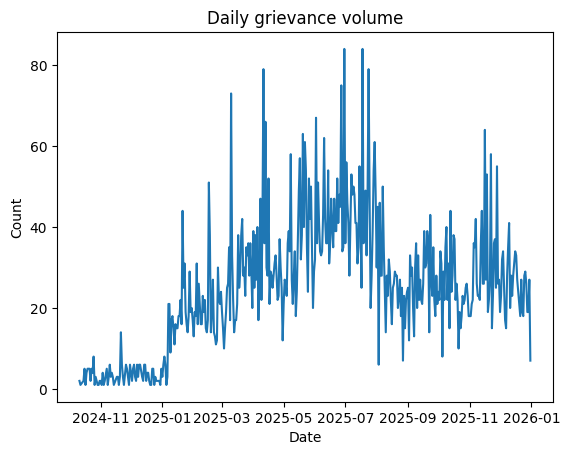

count    439.000000
mean      25.291572
std       15.923524
min        1.000000
25%       15.000000
50%       25.000000
75%       35.000000
max       84.000000
Name: Grievance Id, dtype: float64

In [8]:
# Time buckets
df_kpi = df.copy()
df_kpi["date"] = df_kpi["_created_at"].dt.date
df_kpi["week"] = df_kpi["_created_at"].dt.to_period("W").astype(str)
df_kpi["month"] = df_kpi["_created_at"].dt.to_period("M").astype(str)

# Daily volume
daily = df_kpi.groupby("date")["Grievance Id"].size()

plt.figure()
daily.plot()
plt.title("Daily grievance volume")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

daily.describe()


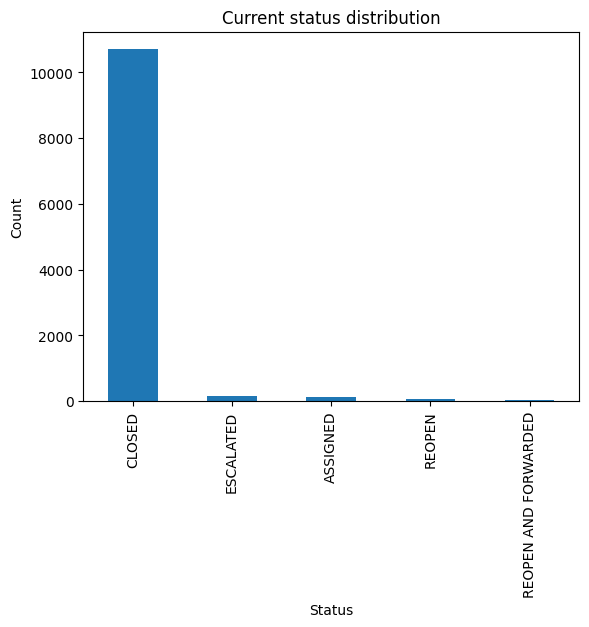

Current Status
CLOSED                  0.9639
ESCALATED               0.0144
ASSIGNED                0.0127
REOPEN                  0.0066
REOPEN AND FORWARDED    0.0024
Name: count, dtype: float64

In [9]:
# Status mix
status = df_kpi["Current Status"].value_counts()
plt.figure()
status.plot(kind="bar")
plt.title("Current status distribution")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

(status / status.sum()).round(4)


age_bucket
<=1d       27
1-3d       27
3-7d       40
7-14d      57
14-30d     62
30-60d     78
60-120d    82
>120d      28
Name: count, dtype: int64

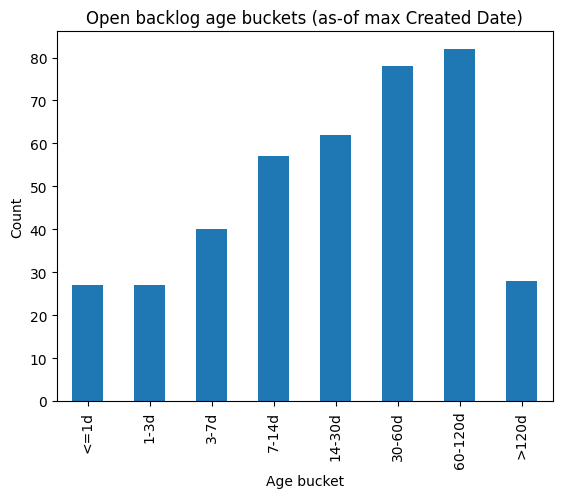

In [10]:
# Backlog (non-closed) and age buckets
asof = df_kpi["_created_at"].max()  # dataset as-of
open_mask = df_kpi["Current Status"].astype(str).str.upper().ne("CLOSED")
df_open = df_kpi.loc[open_mask].copy()
df_open["age_days"] = (asof - df_open["_created_at"]).dt.total_seconds() / 86400.0

df_open["age_bucket"] = pd.cut(
    df_open["age_days"],
    bins=[-1, 1, 3, 7, 14, 30, 60, 120, 99999],
    labels=["<=1d","1-3d","3-7d","7-14d","14-30d","30-60d","60-120d",">120d"]
)

display(df_open["age_bucket"].value_counts(dropna=False).sort_index())

plt.figure()
df_open["age_bucket"].value_counts().sort_index().plot(kind="bar")
plt.title("Open backlog age buckets (as-of max Created Date)")
plt.xlabel("Age bucket")
plt.ylabel("Count")
plt.show()


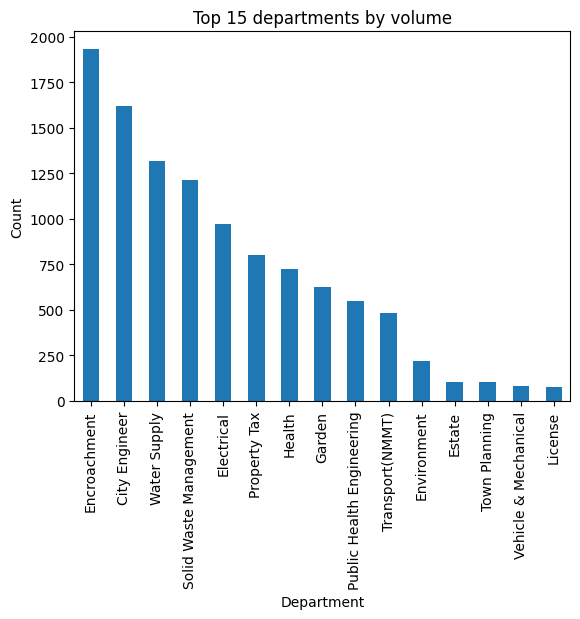

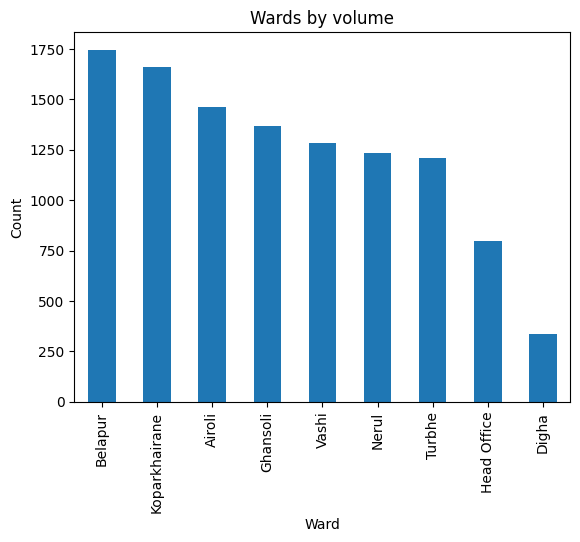

In [11]:
# Pareto: top departments / wards
top_dept = df_kpi["Current Department Name"].value_counts().head(15)
top_ward = df_kpi["Ward Name"].value_counts()

plt.figure()
top_dept.plot(kind="bar")
plt.title("Top 15 departments by volume")
plt.xlabel("Department")
plt.ylabel("Count")
plt.show()

plt.figure()
top_ward.plot(kind="bar")
plt.title("Wards by volume")
plt.xlabel("Ward")
plt.ylabel("Count")
plt.show()


## 6) Text analytics (fast, explainable)

We start with an explainable baseline:
- Clean text (lowercase, strip punctuation, normalize whitespace)
- TF‑IDF features
- Topic discovery via **NMF** (interpretable topics)
- Clustering via **KMeans** to propose “sub‑topics”

These clusters are **not** final categories; they are an *assist* to:
1) propose a taxonomy  
2) speed up labeling  
3) become training data for a supervised classifier (or LLM prompt + eval set)


In [12]:
import string

def clean_text(s):
    s = "" if pd.isna(s) else str(s)
    s = s.lower()
    s = s.replace("\n", " ")
    s = re.sub(r"\s+", " ", s).strip()
    # keep letters/numbers and basic punctuation; remove very noisy chars
    s = s.translate(str.maketrans("", "", string.punctuation))
    return s

df_text = df.copy()
df_text["text"] = (df_text["Complaint Subject"].fillna("").astype(str) + " " +
                   df_text["Complaint Description"].fillna("").astype(str)).map(clean_text)

df_text["text"].str.len().describe()


count    11103.000000
mean       375.251914
std        294.506122
min          2.000000
25%        142.000000
50%        283.000000
75%        548.000000
max       1177.000000
Name: text, dtype: float64

In [13]:
# TF-IDF
vectorizer = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8,
    stop_words="english"
)
X = vectorizer.fit_transform(df_text["text"])

X.shape


(11103, 16083)

In [14]:
# Topic modeling: NMF
n_topics = 12
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=400)
W = nmf.fit_transform(X)
H = nmf.components_

feature_names = np.array(vectorizer.get_feature_names_out())

def top_terms_for_topic(topic_idx, n=12):
    top_idx = np.argsort(H[topic_idx])[::-1][:n]
    return feature_names[top_idx].tolist()

topics = {f"topic_{i}": top_terms_for_topic(i, 14) for i in range(n_topics)}
pd.DataFrame({"topic": list(topics.keys()), "top_terms": list(topics.values())})


,topic,top_terms
0,topic_0,"[light, street light, street, light working, working, working street, working days, days, pole, light street, near, ..."
1,topic_1,"[आह, वर, कर, करण, पर, आण, रस, मह, तर, रव, सर, तक, मध, अस]"
2,topic_2,"[water, supply, water supply, low, days, pressure, supply water, issue, low water, getting, society, shortage, facin..."
3,topic_3,"[property, tax, property tax, payment, paid, online, receipt, 2025, rs, pay, tax paid, received, number, transfer]"
4,topic_4,"[action, illegal, area, request, complaint, sector, construction, nmmc, issue, society, attention, residents, regard..."
5,topic_5,"[bus, route, buses, stop, nmmt, bus stop, service, 65, nmmt bus, kalyan, time, ac, passengers, frequency]"
6,topic_6,"[road, potholes, damaged, footpath, condition, work, traffic, repair, vehicles, roads, bad, uneven, damaged road, pa..."
7,topic_7,"[garbage, waste, days, collected, area, lying, garbage collected, collection, clean, dumping, garbage lying, debris,..."
8,topic_8,"[tree, branches, trees, tree branches, cutting, trimming, cut, fall, tree trimming, tree cutting, footpath, fallen, ..."
9,topic_9,"[lights, street lights, street, lights working, working, working street, garden, lights street, sector, days, dark, ..."


In [15]:
# Cluster discovery (sub-topic candidates)
k = 18
km = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = km.fit_predict(W)

df_text["cluster"] = clusters

# For each cluster, show representative terms by averaging TF-IDF vectors
import scipy.sparse as sp

def cluster_top_terms(cluster_id, topn=15):
    idx = np.where(clusters == cluster_id)[0]
    if len(idx) == 0:
        return []
    sub = X[idx]
    mean_tfidf = np.asarray(sub.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:topn]
    return feature_names[top_idx].tolist()

cluster_summary = []
for c in range(k):
    n = int((df_text["cluster"]==c).sum())
    cluster_summary.append({
        "cluster": c,
        "n": n,
        "top_terms": cluster_top_terms(c, 16)
    })

cluster_df = pd.DataFrame(cluster_summary).sort_values("n", ascending=False)
cluster_df.head(12)


,cluster,n,top_terms
2,2,2499,"[footpath, garden, area, payment, sector, application, nmmc, dog, society, waste, request, mosquito, number, kindly,..."
15,15,1482,"[illegal, action, area, construction, request, complaint, sector, nmmc, society, issue, residents, encroachment, hea..."
1,1,1065,"[आह, कर, वर, करण, तर, मध, बत, मह, आण, रस, लवकर, पर, रव, पय, टर, कचर]"
17,17,1020,"[आह, वर, कर, पर, आण, करण, रस, मह, सर, तर, रव, तक, अस, मध, बत, आपण]"
13,13,671,"[road, footpath, traffic, roads, potholes, parking, vehicles, sector, near, action, work, area, request, condition, ..."
4,4,619,"[property, tax, property tax, payment, paid, online, receipt, rs, pay, 2025, transfer, tax paid, ledger, change, rec..."
10,10,605,"[drainage, line, broken, gutter, water, cover, sewage, chamber, drainage line, pipe, leakage, blocked, overflow, cho..."
16,16,533,"[water, supply, water supply, pressure, issue, days, low, society, request, problem, wastage, nmmc, tank, shortage, ..."
5,5,517,"[water, supply, water supply, low, days, pressure, supply water, issue, low water, society, getting, supply days, fa..."
6,6,377,"[garbage, waste, area, collection, collected, days, garbage collected, lying, road, garbage lying, garbage collectio..."


In [16]:
# Show a few examples from the largest clusters (PII-safe display)
# (robust to missing PII columns in some extracts)
pii_cols = [c for c in ["Reported by User Name", "Mobile No."] if c in df_safe.columns]

sample = df_text.merge(df_safe[["Grievance Id"] + pii_cols], on="Grievance Id", how="left")

cols = [
    "Grievance Id",
    "_created_at",
    "Current Department Name",
    "Ward Name",
    "Current Status",
    "cluster",
    *pii_cols,
    "Complaint Subject",
    "Complaint Description",
]
cols = [c for c in cols if c in sample.columns]

sample = sample.loc[:, cols]

for c in cluster_df.head(5)["cluster"]:
    display(sample[sample["cluster"] == c].head(5))


,Grievance Id,_created_at,Current Department Name,Ward Name,Current Status,cluster,Complaint Subject,Complaint Description
0,NMMC/25/10904,2025-12-31 10:56:00,Encroachment,Belapur,ASSIGNED,2,Illegal non veg food truck parking,Illegal non veg food truck parking on road create nuisance to Residence at late evening time\nThough repeated compla...
4,NMMC/25/10900,2025-12-31 09:35:00,Encroachment,Belapur,ASSIGNED,2,about illegal use by drunkers in sector 2 vegetable market at night time.,myself omkar surve resident of sector 2 cbd belapur wants to complaint against illlegal use of sector 2 bhaji market...
6,NMMC/25/10898,2025-12-31 01:43:00,Health,Koparkhairane,ASSIGNED,2,"Request for Fogging – Mosquito Problem in Sector-5, Koparkhairane","Heavy mosquito breeding in Sector-5, Koparkhairane. Request immediate anti-larval treatment and fogging to prevent d..."
13,NMMC/25/10891,2025-12-30 19:09:00,Administration,Belapur,ASSIGNED,2,Marati,NaN
19,NMMC/25/10885,2025-12-30 16:25:00,Public Health Engineering,Nerul,ASSIGNED,2,"उंदीर जास्त झाले पंचरत्न रेसिडेन्सी सोसायटी, सेक्टर 3, नेरूळ. जीकब चर्च समोर सगळ्या बिल्डिंगमध्ये","उंदीर जास्त झाले पंचरत्न रेसिडेन्सी सोसायटी, सेक्टर 3, नेरूळ.\nजीकब चर्च समोर सगळ्या बिल्डिंगमध्ये"


,Grievance Id,_created_at,Current Department Name,Ward Name,Current Status,cluster,Complaint Subject,Complaint Description
5,NMMC/25/10899,2025-12-31 07:40:00,Environment,Vashi,ASSIGNED,15,Complaint Regarding Persistent Air Pollution and Foul Odour in Vashi,"For the past several weeks, residents in and around Vashi have been experiencing strong chemical smells, poor air qu..."
7,NMMC/25/10897,2025-12-30 23:16:00,Legal and Law,Turbhe,ASSIGNED,15,llegal construction over height developing house,Hera i have came. To inform you near my home the man is building his home but he not taking safety measures and deve...
10,NMMC/25/10894,2025-12-30 21:36:00,Encroachment,Head Office,ASSIGNED,15,Unauthorized encroachment,​I am writing to bring to your notice that a formal complaint was lodged with your department in vashi ward on Decem...
15,NMMC/25/10889,2025-12-30 18:07:00,Environment,Nerul,ASSIGNED,15,"Huge dust getting spilled due to construction activities nearby ..by Delta, Gama, NMS group builders","Huge amount of dust is getting spilled due to the construction activities by the Delta, Gama and NMS builders just n..."
16,NMMC/25/10888,2025-12-30 17:23:00,Municipal Secretary,Nerul,ASSIGNED,15,Unauthorised hawkers on street,"Respected Sir/Madam,\n\nI am writing to bring to your attention the issue of unauthorized street hawkers in our area..."


,Grievance Id,_created_at,Current Department Name,Ward Name,Current Status,cluster,Complaint Subject,Complaint Description
18,NMMC/25/10886,2025-12-30 16:30:00,Garden,Ghansoli,ASSIGNED,1,SIGCE कॉलेजच्या मैदानात जे सी बी मशीनने नैसर्गीक टेकडी फोडण्यात येत आहे.,SIGCE कॉलेजच्या मैदानात जे सी बी मशीनने नैसर्गीक टेकडी फोडण्यात येत आहे. \nयाबाबत तक्रार करण्यात आली होती पण त्याबाब...
30,NMMC/25/10874,2025-12-30 09:26:00,City Engineer,Turbhe,ASSIGNED,1,धुळी बद्दल,"महोदय,\nवर नमूद केलेल्या stop जवळील रस्त्याच्या कडेला nmmc तर्भे काही कामानिमित्त खोदकाम करण्यात आले होते. कामं पूर्..."
42,NMMC/25/10862,2025-12-29 17:54:00,License,Head Office,CLOSED,1,बिना लाइसेंस के दिन-रात बिना इजाज़त के रिहायशी कॉलोनी में चल रही इंडस्ट्रियल फैक्ट्री के खिलाफ कार्रवाई कब होगी ??,कस्तूरा एंटरप्राइजेज शॉप नंबर 3/4/5 प्लॉट नंबर 375 सेक्टर 19 कोपरखैरणे नवी मुंबई भले ही इस फैक्ट्री का लाइसेंस म्यु...
53,NMMC/25/10851,2025-12-28 23:24:00,Health,Head Office,ASSIGNED,1,Polio dose wrong informarion given by cbd bealpur sector 2 NMMC hospital,"पोलिओ डोस संदर्भात तक्रार\n\nनमस्कार,\n \nआम्ही पोलिओ डोस संदर्भात आम्ही NMMC मध्ये नावनोंदणी केली होती, तरीसुद्धा..."
59,NMMC/25/10845,2025-12-28 16:40:00,Encroachment,Nerul,ASSIGNED,1,स्टेशन परिसरातील अनावश्यक कचरायुक्त सिमेंट कुंड्या हटवीण्याबाबत.,अनेक वर्ष कचरायुक्त अनावश्यक सिमेंट कुंड्याच्या वापर अवैध धंदेवाईक बैठक किंवा थुंकदानी म्हणून वापर करीत आहेत. कृपया ...


,Grievance Id,_created_at,Current Department Name,Ward Name,Current Status,cluster,Complaint Subject,Complaint Description
3,NMMC/25/10901,2025-12-31 09:58:00,Town Planning,Vashi,ASSIGNED,17,NMMC ने नव्याने दिलेल्या दुकानाच्या जागेबाबत,"महोदय,\n\nवर दिलेल्या जागेवर आणि इतर ठिकाणी nmmc ने नवीन दुकानाचे गाळे दिले आहेत.ते marginal space चा चुकीचा वापर तर..."
17,NMMC/25/10887,2025-12-30 16:45:00,Environment,Belapur,ASSIGNED,17,SIGCE कॉलेजच्या मैदानात जे सी बी मशीनने नैसर्गीक टेकडी फोडण्यात येत आहे.,SIGCE कॉलेजच्या मैदानात जे सी बी मशीनने नैसर्गीक टेकडी फोडण्यात येत आहे. \nयाबाबत तक्रार करण्यात आली होती पण त्याबाब...
24,NMMC/25/10880,2025-12-30 11:20:00,Encroachment,Turbhe,CLOSED,17,सोसायटीच्या देखभाल टेरेसवर झालेल्या अतिक्रमणाबाबत तक्रार,"भरत शत्रुघ्न सहकारी गृहनिर्माण संस्था (CHSL), प्लॉट क्र. ३ आणि ४, सेक्टर १८, वाशी, आमच्या सोसायटीच्या आवारात नुकत्या..."
26,NMMC/25/10878,2025-12-30 11:32:00,Estate,Airoli,ASSIGNED,17,Refund,"सदर अर्जाद्वारे आपणांस नम्र विनंती करण्यात येत आहे की, मी जांकीबाई कृष्णा माधवी मंगल कार्यालय दिनांक 27 डिसेंबर 2024..."
48,NMMC/25/10856,2025-12-29 14:32:00,Town Planning,Ghansoli,ASSIGNED,17,प्रदुशन होत असले बाबत,नमस्कार सर \nआमचे श्री गणेश सोसायटीचे पाठीमागे गेले बऱ्याच महिन्यांपासून निळकंठ व सिटी इंफ्रा या कन्ट्रक्शन साईड ...


,Grievance Id,_created_at,Current Department Name,Ward Name,Current Status,cluster,Complaint Subject,Complaint Description
12,NMMC/25/10892,2025-12-30 21:03:00,Encroachment,Belapur,ASSIGNED,13,Unauthorised and illegal non veg food truck parking on road,Unauthorised and illegal non veg food truck parking on road opp Mona building serving non vegetarian food and it cre...
33,NMMC/25/10871,2025-12-30 00:42:00,City Engineer,Belapur,ASSIGNED,13,Request for speed breaker,Behind samshan bhumi Due to speeding motorist dangerous driving and overtaking as this strech of road really becomes...
38,NMMC/25/10866,2025-12-29 20:41:00,Electrical,Airoli,ASSIGNED,13,Airoli Mulund Bridge Light not working,"Dear Sir,\n\nI would like to bring to your kind attention that for the past 2–3 months, the street lights on the Mul..."
51,NMMC/25/10853,2025-12-29 12:18:00,Garden,Turbhe,CLOSED,13,Brooming not done regularly,I wish to inform that today when I was using the walking track for walking there was lot of dead leafs on the track ...
67,NMMC/25/10837,2025-12-27 23:11:00,Solid Waste Management,Belapur,CLOSED,13,Solid waste is not getting cleaned for more than one month.,"Dear Sir,\n\nSolid waste is not getting cleaned for more than one month.\nThere are two tin structure on the footpat..."


## 7) From clusters → real “Sub‑Topics” (human + LLM loop)

A robust taxonomy workflow (practical, senior DS approach):

1. **Seed taxonomy** from cluster summaries (above).
2. **Human review** (domain team) to merge/split/rename into business‑friendly sub‑topics.
3. **Create a gold eval set** (300–800 labeled rows): stratified by department/ward/status and cluster.
4. Use **Gemini** (or any LLM) to label sub‑topics with a strict schema:
   - `sub_topic`
   - `confidence`
   - `rationale` (short)
   - `needs_human_review` (bool)

5. Measure quality on eval set (accuracy/F1 + confusion analysis).  
6. Productionize with:
   - rules for low‑confidence → human queue
   - monitoring drift: top n-grams, embedding drift, volume drift, per-dept error rates

Below is a *prompt template* you can use for Gemini to propose sub‑topics consistently.


In [17]:
GEMINI_SUBTOPIC_PROMPT = '''
You are an expert municipal grievance analyst.

TASK:
Given a grievance record (subject + description + department + ward), assign ONE sub-topic from the allowed list.

OUTPUT JSON ONLY (no markdown):
{
  "sub_topic": "<one of ALLOWED_SUB_TOPICS>",
  "confidence": <float 0..1>,
  "needs_human_review": <true|false>,
  "rationale": "<<=25 words>"
}

RULES:
- Choose exactly ONE sub_topic.
- If information is missing/ambiguous OR confidence < 0.65 => needs_human_review = true.
- Do NOT output personal data (names, phone numbers).
- Prefer business-meaningful buckets (actionable) over vague themes.

ALLOWED_SUB_TOPICS:
<PASTE_YOUR_FINAL_TAXONOMY_HERE>

RECORD:
- Department: {department}
- Ward: {ward}
- Subject: {subject}
- Description: {description}
'''.strip()

print(GEMINI_SUBTOPIC_PROMPT[:700] + "\n...")

You are an expert municipal grievance analyst.

TASK:
Given a grievance record (subject + description + department + ward), assign ONE sub-topic from the allowed list.

OUTPUT JSON ONLY (no markdown):
{
  "sub_topic": "<one of ALLOWED_SUB_TOPICS>",
  "confidence": <float 0..1>,
  "needs_human_review": <true|false>,
  "rationale": "<<=25 words>"
}

RULES:
- Choose exactly ONE sub_topic.
- If information is missing/ambiguous OR confidence < 0.65 => needs_human_review = true.
- Do NOT output personal data (names, phone numbers).
- Prefer business-meaningful buckets (actionable) over vague themes.

ALLOWED_SUB_TOPICS:
<PASTE_YOUR_FINAL_TAXONOMY_HERE>

RECORD:
- Department: {department}
- Ward: {
...


## 8) Baseline supervised model (department prediction)

Why do this even if you use an LLM?
- Cheap, fast, stable baseline
- Detect outliers + routing errors
- Guardrail for LLM (disagreement checks)

We train a simple TF‑IDF + Logistic Regression classifier.


In [18]:
# Prepare a compact dataset with enough text
ml = df_text.copy()
ml["y_dept"] = df["Current Department Name"].astype(str)

# Stratified split requires >=2 samples per class; filter ultra-rare departments.
class_counts = ml["y_dept"].value_counts(dropna=False)
keep = class_counts[class_counts >= 2].index
ml2 = ml[ml["y_dept"].isin(keep)].copy()

dropped = len(ml) - len(ml2)
if dropped:
    print(f"Dropping {dropped} rows from departments with <2 samples for stratified split.")

X = vectorizer.fit_transform(ml2["text"])
y = ml2["y_dept"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(classification_report(y_test, pred, zero_division=0))


Dropping 1 rows from departments with <2 samples for stratified split.


                           precision    recall  f1-score   support

                  Account       0.00      0.00      0.00         3
           Administration       0.00      0.00      0.00         7
                    Audit       1.00      1.00      1.00         3
            City Engineer       0.65      0.77      0.71       324
                Computer        0.00      0.00      0.00         7
                Education       0.00      0.00      0.00         6
                 Election       0.00      0.00      0.00         1
               Electrical       0.95      0.92      0.94       194
             Encroachment       0.67      0.91      0.77       387
              Environment       0.79      0.35      0.48        43
                   Estate       0.67      0.10      0.17        21
                     Fire       0.00      0.00      0.00         3
                   Garden       0.82      0.68      0.74       125
                   Health       0.84      0.81      0.82     

## 9) Productization notes (what “senior DS” looks like)

### Minimum viable analytics layer (2–4 weeks)
- KPI Cockpit: volume, backlog, reopen/escalation, department/ward Pareto
- Cluster-driven sub-topic exploration
- Exportable “review queue” for humans (low-confidence / novel clusters)

### Minimum viable AI layer (4–8 weeks)
- Final sub-topic taxonomy (v1) + eval set
- Gemini labeler + human review loop + analytics on label distribution
- Monitoring: drift + per-ward/per-dept performance

### Data improvements to request from Probity/NMMC
To unlock SLA + accountability analytics:
- `Last Updated Date`
- `Closed Date` (or status history table)
- `Channel` (app/web/call center/WhatsApp/etc.)
- `Category` (if exists in source system)
- `Geo` (lat/long or standardized location codes)
- `Assignment history` (who/when it moved between users/depts)

### Governance / Privacy
- PII minimization in all downstream datasets
- Role-based access controls
- Hash IDs for join keys where possible
- Audit logs for data exports


## 10) Next steps checklist

1. Confirm target output: **Sub‑Topic taxonomy** vs **Department routing** vs both.  
2. Add `Closed Date` / status history export (critical for SLA).  
3. Create a 500‑row eval set (stratified by cluster + department + ward).  
4. Iterate taxonomy v1 → v2 using confusion analysis.  
5. Decide production path:
   - LLM-only (Gemini) with eval + monitoring
   - Hybrid: ML baseline + LLM fallback
   - Fully supervised after enough labels
